### Librerias

In [2]:
import unicodedata
import re
import random
import torch
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

### Datasets

In [3]:
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

def read_file(file, reverse=False):
    # Read the file and split into lines
    lines = open(file, encoding='utf-8').read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')[:2]] for l in lines]

    return pairs

In [4]:
pairs = read_file('eng-fra.txt')

In [13]:
random.choice(pairs)

['this is an option to consider .', 'c est une possibilite a envisager .']

In [15]:
SOS_token = 0
EOS_token = 1
PAD_token = 2

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {"SOS": 0, "EOS": 1, "PAD": 2, "UNK": 3}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS", 2: "PAD", 3: "UNK"}
        self.n_words = 4  # Count SOS, EOS, PAD, and UNK

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

    def indexesFromSentence(self, sentence):
        return [self.word2index.get(word, self.word2index["UNK"]) for word in sentence.split(' ')]

    def sentenceFromIndex(self, index):
        return [self.index2word[ix] for ix in index]


In [16]:
MAX_LENGTH = 10

def filterPairs(pairs, filters, lang=0):
    return [p for p in pairs if p[lang].startswith(filters)]

def trimPairs(pairs):
    return [p for p in pairs if len(p[0].split(' ')) < MAX_LENGTH and len(p[1].split(' ')) < MAX_LENGTH]

In [17]:
def prepareData(file, filters=None, reverse=False):

    pairs = read_file(file, reverse)
    print(f"Tenemos {len(pairs)} pares de frases")

    if filters is not None:
        pairs = filterPairs(pairs, filters, int(reverse))
        print(f"Filtramos a {len(pairs)} pares de frases")

    pairs = trimPairs(pairs)
    print(f"Tenemos {len(pairs)} pares de frases con longitud menor de {MAX_LENGTH}")

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang('fra')
        output_lang = Lang('eng')
    else:
        input_lang = Lang('eng')
        output_lang = Lang('fra')

    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])

    # Print vocabulary lengths
    print("Longitud vocabularios:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)

    return input_lang, output_lang, pairs

# Use the updated function to prepare data for English-French translation
input_lang, output_lang, pairs = prepareData('eng-fra.txt')

# Print a random pair to verify
print(random.choice(pairs))


Tenemos 135842 pares de frases
Tenemos 95170 pares de frases con longitud menor de 10
Longitud vocabularios:
eng 10027
fra 16815
['i don t want to hurt her .', 'je ne veux pas la blesser .']


In [18]:
output_lang.indexesFromSentence('Owls are active at night .')

[3, 3, 2536, 3, 3, 16]

In [19]:
output_lang.sentenceFromIndex([1000, 1028, 647, 16])

['jubilez', 'loucha', 'serieuse', '.']

In [51]:
device = "cuda" if torch.cuda.is_available() else "cpu"

class Dataset(torch.utils.data.Dataset):
    def __init__(self, input_lang, output_lang, pairs, max_length):
        self.input_lang = input_lang
        self.output_lang = output_lang
        self.pairs = pairs
        self.max_length = max_length

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, ix):
        inputs = torch.tensor(self.input_lang.indexesFromSentence(self.pairs[ix][0]), device=device, dtype=torch.long)
        outputs = torch.tensor(self.output_lang.indexesFromSentence(self.pairs[ix][1]), device=device, dtype=torch.long)
        # metemos padding a todas las frases hast a la longitud máxima
        return torch.nn.functional.pad(inputs, (0, self.max_length - len(inputs)), 'constant', self.input_lang.word2index['PAD']), \
            torch.nn.functional.pad(outputs, (0, self.max_length - len(outputs)), 'constant', self.output_lang.word2index['PAD'])

# separamos datos en train-test
train_size = len(pairs) * 80 // 100
train = pairs[:train_size]
test = pairs[train_size:]

dataset = {
    'train': Dataset(input_lang, output_lang, train, max_length=MAX_LENGTH),
    'test': Dataset(input_lang, output_lang, test, max_length=MAX_LENGTH)
}

len(dataset['train']), len(dataset['test'])

(76136, 19034)

In [54]:
input_sentence, output_sentence = dataset['train'][1]

input_sentence, output_sentence

(tensor([6, 7, 2, 2, 2, 2, 2, 2, 2, 2]),
 tensor([6, 5, 2, 2, 2, 2, 2, 2, 2, 2]))

In [55]:
input_lang.sentenceFromIndex(input_sentence.tolist()), output_lang.sentenceFromIndex(output_sentence.tolist())

(['run', '!', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD'],
 ['cours', '!', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD'])

In [56]:
dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=64, shuffle=True),
    'test': torch.utils.data.DataLoader(dataset['test'], batch_size=256, shuffle=False),
}

inputs, outputs = next(iter(dataloader['train']))
inputs.shape, outputs.shape

(torch.Size([64, 10]), torch.Size([64, 10]))

In [57]:
class Encoder(torch.nn.Module):
    def __init__(self, input_size, embedding_size=100, hidden_size=100, n_layers=2):
        super().__init__()
        self.hidden_size = hidden_size
        self.embedding = torch.nn.Embedding(input_size, embedding_size)
        self.gru = torch.nn.GRU(embedding_size, hidden_size, num_layers=n_layers, batch_first=True)

    def forward(self, input_sentences):
        embedded = self.embedding(input_sentences)
        outputs, hidden = self.gru(embedded)
        return outputs, hidden

In [58]:
encoder = Encoder(input_size=input_lang.n_words)
encoder_outputs, encoder_hidden = encoder(torch.randint(0, input_lang.n_words, (64, 10)))

# [batch size, seq len, hidden size] 
encoder_outputs.shape

torch.Size([64, 10, 100])

In [59]:
# [num layers, batch size, hidden size]
encoder_hidden.shape

torch.Size([2, 64, 100])

In [60]:
class AttnDecoder(torch.nn.Module):
    def __init__(self, input_size, embedding_size=100, hidden_size=100, n_layers=2, max_length=MAX_LENGTH):
        super().__init__()

        self.embedding = torch.nn.Embedding(input_size, embedding_size)
        self.gru = torch.nn.GRU(embedding_size, hidden_size, num_layers=n_layers, batch_first=True)
        self.out = torch.nn.Linear(hidden_size, input_size)

        # attention
        self.attn = torch.nn.Linear(hidden_size + embedding_size, max_length)
        self.attn_combine = torch.nn.Linear(hidden_size * 2, hidden_size)


    def forward(self, input_words, hidden, encoder_outputs):
        # sacamos los embeddings
        embedded = self.embedding(input_words)
        # calculamos los pesos de la capa de atención
        attn_weights = torch.nn.functional.softmax(self.attn(torch.cat((embedded.squeeze(1), hidden[0]), dim=1)))
        # re-escalamos los outputs del encoder con estos pesos
        attn_applied = torch.bmm(attn_weights.unsqueeze(1), encoder_outputs)
        output = torch.cat((embedded.squeeze(1), attn_applied.squeeze(1)), 1)
        # aplicamos la capa de atención
        output = self.attn_combine(output)
        output = torch.nn.functional.relu(output)
        # a partir de aquí, como siempre. La diferencia es que la entrada a la RNN
        # no es directmanete el embedding sino una combinación del embedding
        # y las salidas del encoder re-escaladas
        output, hidden = self.gru(output.unsqueeze(1), hidden)
        output = self.out(output.squeeze(1))
        return output, hidden, attn_weights

In [61]:
decoder = AttnDecoder(input_size=output_lang.n_words)
decoder_output, decoder_hidden, attn_weights = decoder(torch.randint(0, output_lang.n_words, (64, 1)), encoder_hidden, encoder_outputs)

# [batch size, vocab size]
decoder_output.shape

C:\Users\victus\AppData\Local\Temp\ipykernel_7672\1629649894.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  attn_weights = torch.nn.functional.softmax(self.attn(torch.cat((embedded.squeeze(1), hidden[0]), dim=1)))


torch.Size([64, 16815])

In [64]:
# [num layers, batch size, hidden size]
decoder_hidden.shape

torch.Size([2, 64, 100])

In [65]:
# [batch size, max_length]
attn_weights.shape

torch.Size([64, 10])

In [66]:
def fit(encoder, decoder, dataloader, epochs=10):
    encoder.to(device)
    decoder.to(device)
    encoder_optimizer = torch.optim.Adam(encoder.parameters(), lr=1e-3)
    decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=1e-3)
    criterion = torch.nn.CrossEntropyLoss()
    for epoch in range(1, epochs+1):
        encoder.train()
        decoder.train()
        train_loss = []
        bar = tqdm(dataloader['train'])
        for batch in bar:
            input_sentences, output_sentences = batch
            bs = input_sentences.shape[0]
            loss = 0
            encoder_optimizer.zero_grad()
            decoder_optimizer.zero_grad()
            # obtenemos el último estado oculto del encoder
            encoder_outputs, hidden = encoder(input_sentences)
            # calculamos las salidas del decoder de manera recurrente
            decoder_input = torch.tensor([[output_lang.word2index['SOS']] for b in range(bs)], device=device)
            for i in range(output_sentences.shape[1]):
                output, hidden, attn_weights = decoder(decoder_input, hidden, encoder_outputs)
                loss += criterion(output, output_sentences[:, i].view(bs))
                # el siguiente input será la palabra predicha
                decoder_input = torch.argmax(output, axis=1).view(bs, 1)
            # optimización
            loss.backward()
            encoder_optimizer.step()
            decoder_optimizer.step()
            train_loss.append(loss.item())
            bar.set_description(f"Epoch {epoch}/{epochs} loss {np.mean(train_loss):.5f}")

        val_loss = []
        encoder.eval()
        decoder.eval()
        with torch.no_grad():
            bar = tqdm(dataloader['test'])
            for batch in bar:
                input_sentences, output_sentences = batch
                bs = input_sentences.shape[0]
                loss = 0
                # obtenemos el último estado oculto del encoder
                encoder_outputs, hidden = encoder(input_sentences)
                # calculamos las salidas del decoder de manera recurrente
                decoder_input = torch.tensor([[output_lang.word2index['SOS']] for b in range(bs)], device=device)
                for i in range(output_sentences.shape[1]):
                    output, hidden, attn_weights = decoder(decoder_input, hidden, encoder_outputs)
                    loss += criterion(output, output_sentences[:, i].view(bs))
                    # el siguiente input será la palabra predicha
                    decoder_input = torch.argmax(output, axis=1).view(bs, 1)
                val_loss.append(loss.item())
                bar.set_description(f"Epoch {epoch}/{epochs} val_loss {np.mean(val_loss):.5f}")

In [67]:
fit(encoder, decoder, dataloader, epochs=30)

  0%|          | 0/1190 [00:00<?, ?it/s]C:\Users\victus\AppData\Local\Temp\ipykernel_7672\1629649894.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  attn_weights = torch.nn.functional.softmax(self.attn(torch.cat((embedded.squeeze(1), hidden[0]), dim=1)))
Epoch 30/30 val_loss 43.83965: 100%|██████████| 75/75 [00:19<00:00,  3.88it/s]


In [70]:
input_sentence, output_sentence = dataset['train'][5000]
input_lang.sentenceFromIndex(input_sentence.tolist()), output_lang.sentenceFromIndex(output_sentence.tolist())

(['is', 'he', 'at', 'home', '?', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD'],
 ['est', 'il', 'chez', 'lui', '?', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD'])

In [74]:
def predict(input_sentence):
    # obtener el último estado oculto del encoder
    encoder_outputs, hidden = encoder(input_sentence.unsqueeze(0))
    # calcular las salidas del decoder de manera recurrente
    decoder_input = torch.tensor([[output_lang.word2index['SOS']]], device=device)
    # iterar hasta que el decoder nos de el token <eos> o hasta que el max length sea alcanzado
    outputs = []
    decoder_attentions = torch.zeros(MAX_LENGTH, MAX_LENGTH)
    i = 0
    while True:
        output, hidden, attn_weights = decoder(decoder_input, hidden, encoder_outputs)
        if i < MAX_LENGTH:
            decoder_attentions[i] = attn_weights.data
        decoder_input = torch.argmax(output, axis=1).view(1, 1)
        outputs.append(decoder_input.cpu().item())
        if decoder_input.item() == output_lang.word2index['EOS'] or i >= MAX_LENGTH - 1:
            break
        i += 1
    return output_lang.sentenceFromIndex(outputs), decoder_attentions[:i+1]

In [76]:
output_words, attn = predict(input_sentence)
output_words

C:\Users\victus\AppData\Local\Temp\ipykernel_7672\1629649894.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  attn_weights = torch.nn.functional.softmax(self.attn(torch.cat((embedded.squeeze(1), hidden[0]), dim=1)))


['est', 'il', 'a', 'la', 'maison', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD']

In [79]:
def showAttention(input_sentence, output_words, attentions):
    try:
        lim1 = input_sentence.index('EOS') + 1
    except ValueError:
        lim1 = len(input_sentence)

    try:
        lim2 = output_words.index('EOS') + 1
    except ValueError:
        lim2 = len(output_words)

    fig = plt.figure(dpi=100)
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions[:lim2, :lim1].numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([' '] + input_sentence[:lim1], rotation=90)
    ax.set_yticklabels([' '] + output_words[:lim2])

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

C:\Users\victus\AppData\Local\Temp\ipykernel_7672\2628931795.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([' '] + input_sentence[:lim1], rotation=90)
C:\Users\victus\AppData\Local\Temp\ipykernel_7672\2628931795.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([' '] + output_words[:lim2])


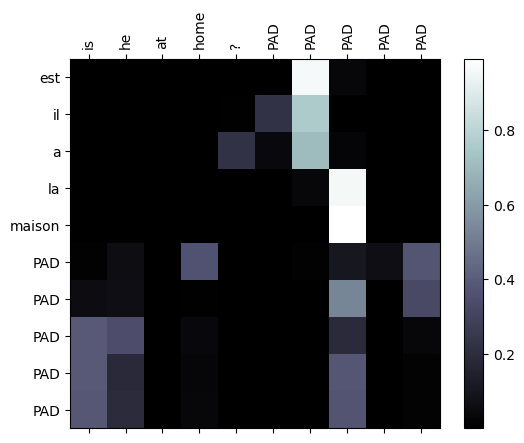

In [80]:
showAttention(input_lang.sentenceFromIndex(input_sentence.tolist()), output_words, attn)